In [9]:
import os
import numpy as np
import spectral.io.envi as envi
import matplotlib.pyplot as plt
from hsi_utils import *
from skimage.filters import threshold_multiotsu
from skimage.measure import label
from sklearn.decomposition import PCA

In [2]:
# Define the path to the main data folder: code will iterate trough relvant files
main_data_folder = './data/img_test'    

#check if data path exists !
print(os.path.isdir(main_data_folder))

# Initialize the HSI dataset and define file extension: contains all paths of hdr and data files
dataset =HsiDataset(main_data_folder,data_ext='hyspex') #raw files from the camera have '.hyspex' extension , corrected files have '.ref' extension

True


In [3]:
save_folder = './data/img_test'   +  '/ref_corrected'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [4]:
HSIreader = HsiReader(dataset)
idx=0   
HSIreader.read_image(idx)

In [5]:
hypercube= HSIreader.get_hsi()
#Sample some spectra to determine generic pca laodings
n_samples = 10000
x_idx = np.random.randint(0, hypercube.shape[0], size=n_samples)
y_idx = np.random.randint(0, hypercube.shape[1], size=n_samples)

spectral_samples = hypercube[x_idx, y_idx, :]

nb_pca_comp =3
pca = PCA(n_components=nb_pca_comp)
pca_scores = pca.fit_transform(spectral_samples)
pca_loadings =pca.components_.T*np.sqrt(pca.explained_variance_)

In [6]:
score_img = HSIreader.project_pca_scores(pca_loadings)

In [19]:
score_pc_ref = score_img[:,:,0]   
thresholds = threshold_multiotsu(score_pc_ref, classes=3)
segmented = np.digitize(score_pc_ref, bins=thresholds)

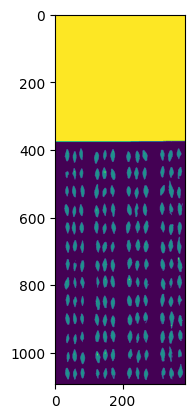

In [20]:
plt.figure()
plt.imshow(segmented)
plt.show(block=False)

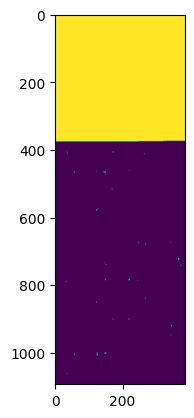

In [31]:
ref_image = (segmented==2)
plt.figure()
plt.imshow(ref_image)
plt.show(block=False)

In [ ]:
reference_mask=np.repeat(ref_image[:, :, np.newaxis], hypercube.shape[2], axis=2)
spectralon = np.where(reference_mask, hypercube, 0)

avg_spectralon = np.sum(spectralon, axis=0)
num_valid_pixels = np.sum(reference_mask, axis=0)
avg_spectralon /= num_valid_pixels    
avg_spectralon[num_valid_pixels == 0]  = np.nan 
        
hypercube = hypercube / avg_spectralon[np.newaxis, :, :]     
hypercube_scaled = (hypercube * 65536).astype(np.uint16)  # 65536 = 2 power 16, storing small data and not float64 (double) can re-normalise [0,1] for plot only


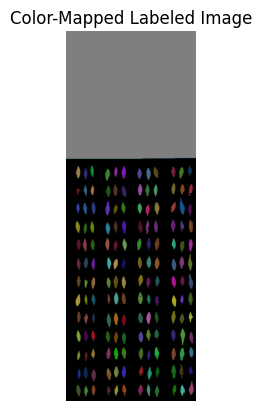

In [ ]:
#get a labelled image of each kernel
labeled_image = label(segmented)

color_image = color_labels(labeled_image)

plt.figure()
plt.imshow(color_image)
plt.title('Color-Mapped Labeled Image')
plt.axis('off')
plt.show(block=False)